*Luis Antonio Ortega Andrés  
Antonio Coín Castro*

# Approximation of the kernel matrix

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the quality of the approximation to the kernel matrix using random features of different types (RBF, Matérn) and Nyström features.

Note that even the best results for classification need not be obtained by the method that gives the best approximation to the kernel matrix. The reason is that the approximation can have a regularization effect that may improve the accuracy of the predictions on the test set.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import rbf_kernel
from sklearn import datasets
from sklearn.kernel_approximation import RBFSampler
from sklearn.gaussian_process.kernels import Matern

import kernel_approximation as ka

%load_ext autoreload
%autoreload 2

seed = 0
np.random.seed(seed)  # for reproducible results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate dataset

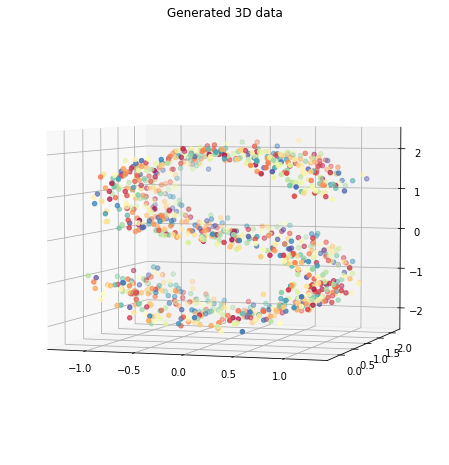

In [12]:
# Generate 3D data
n_instances = 1000
X, color = datasets.make_s_curve(n_instances, 
                                 noise=0.1, 
                                 random_state=seed)
X = X[np.argsort(color)]

# Visualize dataset
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
ax.set_title("Generated 3D data")
plt.show()

## Random features with RBF kernel

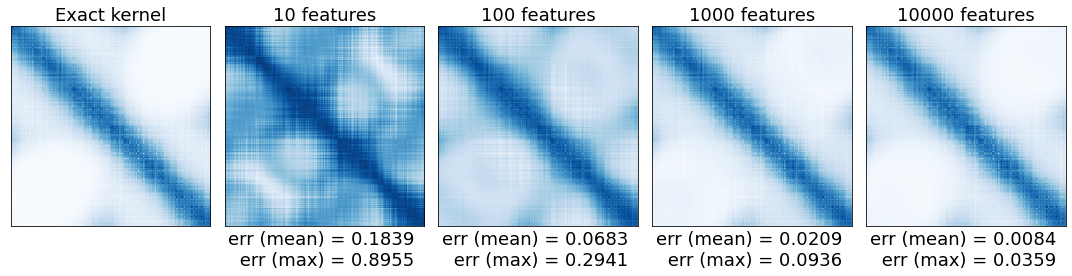

In [13]:
# RBF kernel parameters
sigma = 1.0
gamma = 1.0/(2.0*sigma**2)

# Kernel function
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


# Create an instance of the random features object
rbf_sampler = ka.RandomFeaturesSamplerRBF(
    sigma=sigma, 
    random_state=seed
)

# Plot the approximation to the kernel matrix

n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    kernel,
    rbf_sampler,
    n_random_features
)

Looking at the results, incresing the number of features decreases the resulting error (in mean and maximum value) up to a desirable value. Using only 100 features (of the 1 million availables) reduces the mean error up to 0.06, and using 1% of the total features further reduces it to 0.008.

## Random features with Matérn kernel

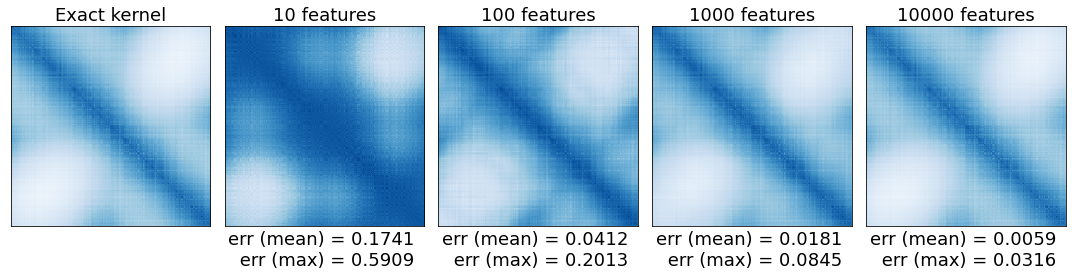

In [14]:
# Matérn kernel parameters
length_scale = 3.0
nu = 0.5

# Kernel function
kernel_matern = Matern(length_scale=length_scale, nu=nu)

def kernel(X, Y):
    return kernel_matern(X, Y)


# Create an instance of the random features object
matern_sampler = ka.RandomFeaturesSamplerMatern(
    scale=length_scale, 
    nu=nu,
    random_state=seed,
)

# Plot the approximation to the kernel matrix

n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    kernel,
    matern_sampler,
    n_random_features
)

In this case, the usage of the Matérn kernel enhances the performance of the kernel method, leading to better results compared to the RBF kernel with every set of features.

## Nyström features with RBF kernel

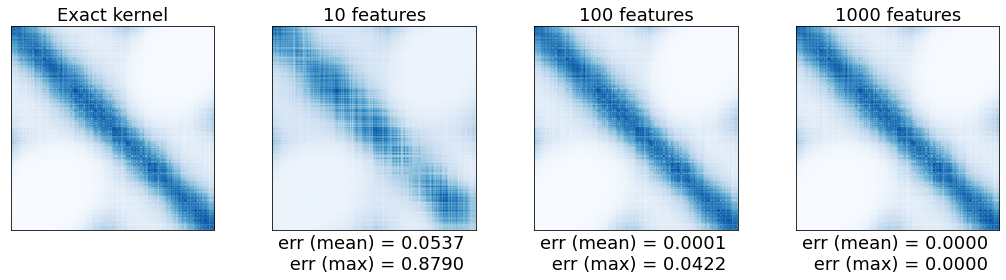

In [15]:
# Kernel parameters
sigma = 1.0
gamma = 1.0/(2.0*sigma**2)

# Kernel function
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


# Create an instance of the Nyström features object
nystroem_sampler = ka.NystroemFeaturesSampler(
    kernel=kernel,
    random_state=seed,
)

# Plot the approximation to the kernel matrix

n_nystroem_features = [10, 100, 1000]

ka.demo_kernel_approximation_features(
    X,
    kernel,
    nystroem_sampler,
    n_nystroem_features
)

In order to compare the performance of this method given a fixed number of features it is necessary to use the square on the other methods. 

In this case, using 10 features leads to a mean error of 0.053, which is just between the results of the previous methods using 100 features.

On the other hand, using 1000 features leads to a situation where all the features of the problem are used, giving 0 error.

### Approximation of unseen points

We compute an approximation of the kernel matrix $k(X_{test}, X)$ using the fitted Nyström features from the data matrix $X$. Specifically, we have:

$$\hat k (X_{test}, X)=\Phi(X_{test})\Phi(X)^T=(k(X_{test}, X_J)(W^{+})^{1/2})((W^{+})^{1/2}k(X_J,X)),$$

where $X_J$ is the subset of $X$ that contains only the $J$ randomly sampled columns.

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


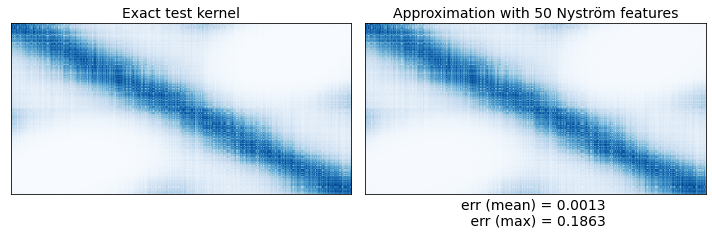

In [16]:
# Generate test data
n_instances = 500
Xt, color_t = datasets.make_s_curve(n_instances, 
                                    noise=0.05, 
                                    random_state=seed)
Xt = Xt[np.argsort(color_t)]

# Compute genuine kernel (test) matrix
Kt = kernel(Xt, X)

# Compute kernel (test) matrix approximation
n_features = 50
Kt_hat = nystroem_sampler.set_params(
    n_components=n_features
).approximate_kernel_matrix(X, Xt)

# Set plot options
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 7)
font = {'fontname': 'arial', 'fontsize': 14}

# Plot original kernel
kernel_matrix = kernel(X, X)
axes[0].imshow(Kt, cmap=plt.cm.Blues)
axes[0].set_title('Exact test kernel', **font)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot approximated kernel and print absolute errors
axes[1].imshow(Kt_hat, cmap=plt.cm.Blues)
axes[1].set_title(
    'Approximation with {} Nyström features'.format(
        n_features
    ), **font)
axes[1].set_xticks([])
axes[1].set_yticks([])
err_approx = Kt - Kt_hat
err_mean = np.mean(np.abs(err_approx))
err_max = np.max(np.abs(err_approx))
axes[1].set_xlabel(
    'err (mean) = {:.4f} \n err (max) = {:.4f}'.format(
        err_mean,
        err_max
    ), **font)

plt.tight_layout()
plt.show()

### Error curve analysis

We study the dependence of the mean error with respect to the number of features sampled for the different random feature models. 

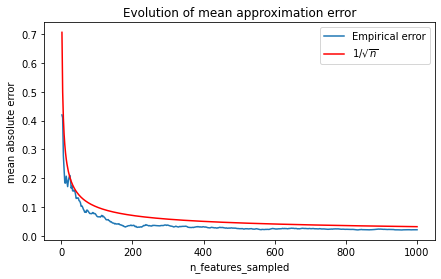

In [17]:
# Random Features RBF error analysis

sigma = 1.0
gamma = 1.0/(2.0*sigma**2)

def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


features_range = ka.plot_mean_approx_err(
    X,
    kernel,
    rbf_sampler,
    1000
)

plt.plot(features_range, 1.0/np.sqrt(features_range),
         color='red', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

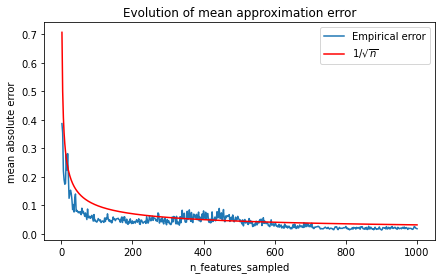

In [18]:
# Random Features Matérn error analysis

length_scale = 3.0
nu = 0.5
kernel_matern = Matern(length_scale=length_scale, nu=nu)

def kernel(X, Y):
    return kernel_matern(X, Y)


features_range = ka.plot_mean_approx_err(
    X,
    kernel,
    matern_sampler,
    1000
)

plt.plot(features_range, 1.0/np.sqrt(features_range),
         color='red', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

In this two cases (Random features), the empirical error is compared with $1/\sqrt{n}$ as this is the error rate of the subjacent Monte Carlo method. 

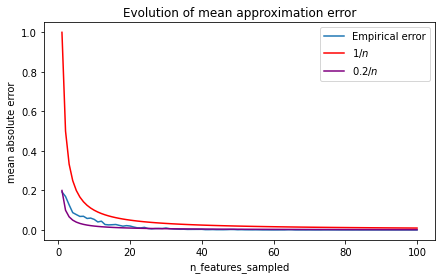

In [22]:
# Nyström features RBF error analysis

sigma = 1.0
gamma = 1.0/(2.0*sigma**2)

def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


features_range = ka.plot_mean_approx_err(
    X,
    kernel,
    nystroem_sampler,
    100,
    start=1,
    step=1
)

plt.plot(features_range, 1/features_range,
         color='red', label=r"$1/n$")
plt.plot(features_range, 0.2/features_range,
         color='purple', label=r"$0.2/n$")
plt.legend()
plt.show()

In this case, as there is no Monte Carlo behaviour, there is no reason to comparare the error with $1/\sqrt{n}$, instead, we have found that the error rate is nead $1/n$. 

No theoretical results that support this error rate have been found, but it seems to fit the error reasonable well. There might exist a proportionality constant that makes the error begin from 0.2, independently of the size of the dataset and the number of features used.